Code taken and adapted from TensorFlow Tutorials: Neural machine translation with attention

https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([target for target, context in pairs])
  target = np.array([context for target, context in pairs])

  return target, context

In [ ]:
spa_raw, eng_raw = load_data(path_to_file)
print(eng_raw[-3])

A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.


In [ ]:
print(spa_raw[-3])

Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático.


In [ ]:
BUFFER_SIZE = len(eng_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(spa_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((eng_raw[is_train], spa_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((eng_raw[~is_train], spa_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
example_text = tf.constant('How was the Eve of New Year party?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'How was the Eve of New Year party?'
b'How was the Eve of New Year party?'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

How was the Eve of New Year party?
[START] how was the eve of new year party ? [END]


In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'the',
 'i',
 'to',
 'you',
 'tom',
 'a',
 '?',
 'is',
 'he',
 'in',
 'of',
 'that',
 'it',
 ',',
 'was']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en',
 'es',
 'un',
 'se',
 'me',
 ',']

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2    8  108 1415 1735    1  620   69    8   28]

[   2    9  180  521  531    1   45   76 2676    4]
[   9  180  521  531    1   45   76 2676    4    3]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    #shape_checker = ShapeChecker()
    #shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    #shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    #shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    #shape_checker = ShapeChecker()

    #shape_checker(x, 'batch t units')
    #shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    #shape_checker(x, 'batch t units')
    #shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    #shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 14, 256)
Attention result, shape (batch, t, units): (64, 14, 256)
Attention weights, shape (batch, t, s):    (64, 14, 16)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ], dtype=float32)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  
  #shape_checker = ShapeChecker()
  #shape_checker(x, 'batch t')
  #shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  #shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  #shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  #shape_checker(x, 'batch t units')
  #shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  #shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 16, 256)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'aves bajando oro animal podrias entiendo exitoso pocos entra ganas',
       b'presentes darte viene haberse similar prestamo coser maneras ayudaria decirlo',
       b'buscado rendirse firme tema ipad panico postura fiable soportarlo medalla'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 5000)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=50, return_dict=True)

50/50 [==============================] - 11s 22ms/step - loss: 8.5175 - masked_acc: 2.6525e-04 - masked_loss: 8.5175


{'loss': 8.517463684082031,
 'masked_acc': 0.0002652520197443664,
 'masked_loss': 8.517463684082031}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=200,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/200
100/100 [==============================] - 33s 161ms/step - loss: 5.0469 - masked_acc: 0.2652 - masked_loss: 5.0469 - val_loss: 4.1248 - val_masked_acc: 0.3621 - val_masked_loss: 4.1248
Epoch 2/200
100/100 [==============================] - 6s 58ms/step - loss: 3.7643 - masked_acc: 0.4028 - masked_loss: 3.7643 - val_loss: 3.4128 - val_masked_acc: 0.4431 - val_masked_loss: 3.4128
Epoch 3/200
100/100 [==============================] - 6s 55ms/step - loss: 3.1494 - masked_acc: 0.4744 - masked_loss: 3.1494 - val_loss: 2.9393 - val_masked_acc: 0.5001 - val_masked_loss: 2.9393
Epoch 4/200
100/100 [==============================] - 4s 44ms/step - loss: 2.7433 - masked_acc: 0.5267 - masked_loss: 2.7433 - val_loss: 2.5394 - val_masked_acc: 0.5602 - val_masked_loss: 2.5394
Epoch 5/200
100/100 [==============================] - 6s 57ms/step - loss: 2.4288 - masked_acc: 0.5681 - masked_loss: 2.4288 - val_loss: 2.3827 - val_masked_acc: 0.5678 - val_masked_loss: 2.3827
Epoch 6/200
100/10

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['Hello how is going your day?'])
result[0].numpy().decode()

'¿ a [UNK] tambien va a ir tu dia ? '

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)


In [ ]:
export = Export(model)

In [ ]:
inputs = [
    'It is really cold here',
    'This is my life.', 
    'His room is a mess.'
]

In [ ]:
_ = export.translate(tf.constant(inputs))

In [ ]:
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [ ]:
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

hace mucho frio aqui .                                             
esta es mi vida .                                             
su habitacion es un desastre .                                            



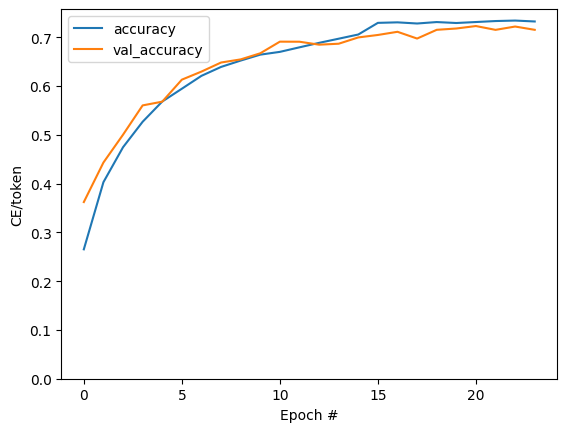

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from typing import List
from loguru import logger

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

@app.post("/translate/eng_to_spa")
async def create_items(text: List[str]):
    logger.info(text)
    result = reloaded.translate(tf.constant(text))
    logger.info(result)
    print(result)
    return {"result": True, "data": result[0].numpy().decode()}


In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: https://67d8-35-231-6-15.ngrok.io


INFO:     Started server process [28045]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
2023-04-17 02:29:54.628 | INFO     | __main__:create_items:18 - ['Where are you from ?']
2023-04-17 02:29:54.765 | INFO     | __main__:create_items:20 - tf.Tensor([b'\xc2\xbf donde estan usted ?                                             '], shape=(1,), dtype=string)


tf.Tensor([b'\xc2\xbf donde estan usted ?                                             '], shape=(1,), dtype=string)
INFO:     54.86.50.139:0 - "POST /translate/eng_to_spa HTTP/1.1" 200 OK


2023-04-17 02:30:06.266 | INFO     | __main__:create_items:18 - ['Hello Oscar']
2023-04-17 02:30:06.396 | INFO     | __main__:create_items:20 - tf.Tensor([b'[UNK] a [UNK] .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'[UNK] a [UNK] .                                              '], shape=(1,), dtype=string)
INFO:     54.86.50.139:0 - "POST /translate/eng_to_spa HTTP/1.1" 200 OK


2023-04-17 02:30:13.688 | INFO     | __main__:create_items:18 - ['Hi']
2023-04-17 02:30:13.813 | INFO     | __main__:create_items:20 - tf.Tensor([b'[UNK] de [UNK] ?                                              '], shape=(1,), dtype=string)


tf.Tensor([b'[UNK] de [UNK] ?                                              '], shape=(1,), dtype=string)
INFO:     54.86.50.139:0 - "POST /translate/eng_to_spa HTTP/1.1" 200 OK


2023-04-17 02:30:23.443 | INFO     | __main__:create_items:18 - ['Tomorrow']
2023-04-17 02:30:23.573 | INFO     | __main__:create_items:20 - tf.Tensor([b'manana manana .                                               '], shape=(1,), dtype=string)


tf.Tensor([b'manana manana .                                               '], shape=(1,), dtype=string)
INFO:     54.86.50.139:0 - "POST /translate/eng_to_spa HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [28045]
